(15, 15)


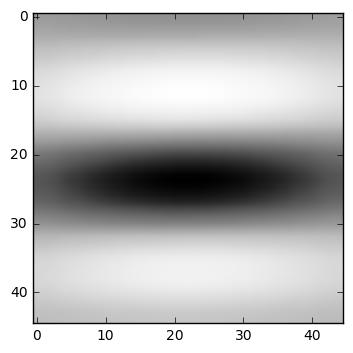

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

def getRandomGaborParams(size):
    
    theta = np.pi*(2*rand() - 1)
    psi = np.pi*rand()
    sigma = 3*np.abs(randn()) + 10e-3
    lambd = 5*np.abs(randn()) + 10e-3
    gamma = np.pi*rand()
    return {'ksize':size, 'sigma':sigma, 'theta': theta, 'lambd':lambd, 'gamma':gamma, 'psi': psi}
    

# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold

params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
print(g_kernel.shape)

img = cv2.imread('cat.jpg',0)
filtered_img = cv2.filter2D(img, cv2.CV_32F, g_kernel)

h, w = g_kernel.shape[:2]
g_show = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_show, cmap='Greys')
plt.show()

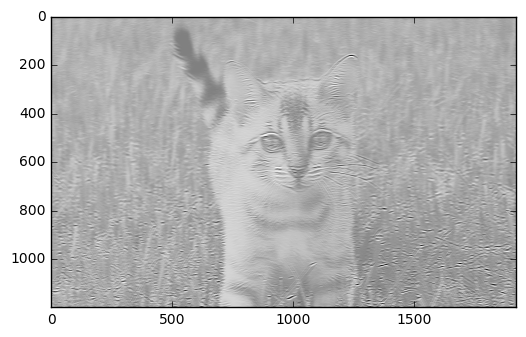

In [2]:
plt.imshow(filtered_img, cmap='Greys')
plt.show()

## My Gabor filter implementation

 Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, `sigma_x`
        and `sigma_y` will decrease with increasing frequency. This value is
        ignored if `sigma_x` and `sigma_y` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.

In [3]:
def myGaborKernel(size = 9, frequency = 1, theta=0, sigma_x=5, sigma_y=5, psi=0):

    x0 = np.ceil(max(size/2, 1))
    y0 = np.ceil(max(size/2, 1))
    print(x0,y0)
    y, x = np.mgrid[-y0+1:y0, -x0+1:x0]

    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    #g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * rotx + psi))
    
    return g

C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


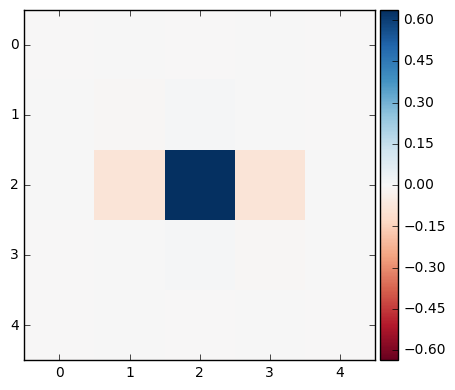

In [4]:

>>> from skimage.filters import gabor_kernel
>>> from skimage import io
>>> from matplotlib import pyplot as plt  # doctest: +SKIP
>>> gk = gabor_kernel(frequency=0.5, sigma_x = 0.5, sigma_y = 0.5, theta=0.5)
>>> plt.figure()        # doctest: +SKIP
>>> io.imshow(gk.real)  # doctest: +SKIP
>>> io.show()           # doctest: +SKIP

In [5]:
gk.shape

(5, 5)

In [6]:
torch.cos(torch.Tensor([1.05]))

NameError: name 'torch' is not defined

8.0 8.0


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


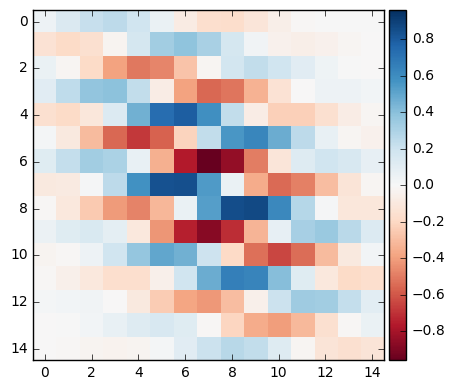

In [7]:
gkm = myGaborKernel(frequency=2, sigma_x = 5, sigma_y = 3, theta=1, size = 15, psi=1)
plt.figure()        # doctest: +SKIP
io.imshow(gkm.real)  # doctest: +SKIP
io.show()

# Torch implementation

In [8]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [149]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        
        self.device = "cpu"# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]
        self.y, self.x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
        self.y, self.x = self.y.to(self.device), self.x.to(self.device)
        
        self.sigma_x = nn.Parameter((self.kernel_size[0]/5)*torch.rand(in_channels*out_channels))
        self.sigma_y = nn.Parameter((self.kernel_size[0]/5)*torch.rand(in_channels*out_channels))
        self.freq = nn.Parameter(self.kernel_size[0]*torch.rand(in_channels*out_channels))
        self.theta = nn.Parameter(6.28*torch.rand(in_channels*out_channels))
        self.psi = nn.Parameter(6.28*torch.rand(in_channels*out_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        #y, x = self.y.to(self.device), self.x.to(self.device)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                
                weight = torch.empty(self.weight.shape, requires_grad=False, device=self.device)
                g = torch.empty(self.y.shape, device=self.device)
                
                sigma_x = self.sigma_x[i*j].expand_as(self.y)
                sigma_y = self.sigma_y[i*j].expand_as(self.y)
                freq = self.freq[i*j].expand_as(self.y)
                theta = self.theta[i*j].expand_as(self.y)
                psi = self.psi[i*j].expand_as(self.y)
                
                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta) 
                
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2)) * torch.cos(2 * 3.14 * freq * rotx + psi)
                weight[j,i] = g
        self.weight.data = weight
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [236]:
import torch.nn as nn
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair


class MyGabor(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)

        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, False, _pair(0), groups, bias)

        self.sigma_x = nn.Parameter(torch.rand(in_channels*out_channels))
        self.sigma_y = nn.Parameter(torch.rand(in_channels*out_channels))
        self.freq = nn.Parameter(torch.rand(in_channels*out_channels))
        self.theta = nn.Parameter(torch.rand(in_channels*out_channels))
        self.psi = nn.Parameter(torch.rand(in_channels*out_channels))
        #self.evaluate = False

    # def eval(self):
        #self.evaluate = True

    # def train(self):
        #self.evaluate = False

    def forward(self, input):
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''

        x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]

        weight = torch.empty(self.weight.shape, requires_grad=False)
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                y, x = torch.meshgrid([torch.arange(-y0+1, y0), torch.arange(-x0+1, x0)])

                sigma_x = self.sigma_x[i*j].expand_as(y)
                sigma_y = self.sigma_y[i*j].expand_as(y)
                freq = self.freq[i*j].expand_as(y)
                theta = self.theta[i*j].expand_as(y)
                psi = self.psi[i*j].expand_as(y)

                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta)
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi)
                weight[j, i] = g
        self.weight = nn.Parameter(weight)
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


## GNet sample

In [237]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [238]:
transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

train_set = dset.MNIST(root='', train=True, download=True, transform=transform)
test_set = dset.MNIST(root='', train=False, download=True, transform=transform)

batch_size = 32

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 1875
==>>> total testing batch number: 313


In [239]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        self.g1 = MyGabor(1, 3, kernel_size=(7,7))
        self.p1 = nn.MaxPool2d(23, stride=1)
        self.g2 = MyGabor(3, 5, kernel_size=(7,7))
        self.p2 = nn.MaxPool2d(23, stride=1)
        self.g3 = MyGabor(5, 7, kernel_size=(7,7))
        self.p3 = nn.MaxPool2d(23, stride=1)
        
        self.fc4 = nn.Linear(16*16*7, 10)

    def forward(self, x):
        x = self.p1(F.relu(self.g1(x)))
        x = self.p2(F.relu(self.g2(x)))
        x = self.p3(F.relu(self.g3(x)))
        
        x = x.view(-1, 16*16*7)
        x = F.softmax(self.fc4(x))
        return x

In [240]:
device = "cpu"# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net()
net = net.to(device)

cpu


In [241]:
from time import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to, labels
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to('cpu')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 20))
            print(net.fc4.weight.grad)
            running_loss = 0.0
            
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = net(data).to('cpu')
            test_loss += criterion(output, target) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

print('Finished Training')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,    20] loss: 2.363
tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]])


KeyboardInterrupt: 

In [247]:
net.g1.theta.grad

tensor([0., 0., 0.])

### Очень странные результаты: точность больше 50% после первых 20 батчей.
TODO: проверить на ошибки

## ConvNet comparison

In [50]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        
        self.c1 = nn.Conv2d(1, 3, kernel_size=(7,7), padding=0)
        self.c2 = nn.Conv2d(3, 5, kernel_size=(7,7), padding=0)
        self.c3 = nn.Conv2d(5, 7, kernel_size=(7,7), padding=0)
        
        self.p1 = nn.MaxPool2d(23, stride=1)
        
        self.fc4 = nn.Linear(16*16*7, 10)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.p1(x)
        x = F.relu(self.c2(x))
        x = self.p1(x)
        x = F.relu(self.c3(x))
        x = self.p1(x)
        
        x = x.view(-1, 16*16*7)
        x = F.softmax(self.fc4(x))
        return x

In [71]:
convnet = ConvNet()
convnet.to(device)

ConvNet(
  (c1): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1))
  (c2): Conv2d(3, 5, kernel_size=(7, 7), stride=(1, 1))
  (c3): Conv2d(5, 7, kernel_size=(7, 7), stride=(1, 1))
  (p1): MaxPool2d(kernel_size=23, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=1792, out_features=10, bias=True)
)

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.9)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convnet(inputs).to('cpu')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
    #convnet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = convnet(data).to('cpu')
            test_loss += criterion(output, target) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))

print('Finished Training')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   200] loss: 23.608
[1,   400] loss: 23.619
[1,   600] loss: 23.633
[1,   800] loss: 23.615
[1,  1000] loss: 23.596
[1,  1200] loss: 23.633
[1,  1400] loss: 23.680
[1,  1600] loss: 23.621
[1,  1800] loss: 23.599

Test set: Average loss: 0.0740, Accuracy: 958/10000 (10%)

[2,   200] loss: 23.610
[2,   400] loss: 23.637
[2,   600] loss: 23.674
[2,   800] loss: 23.587
[2,  1000] loss: 23.591
[2,  1200] loss: 23.616
[2,  1400] loss: 23.612
[2,  1600] loss: 23.641
[2,  1800] loss: 23.644

Test set: Average loss: 0.0740, Accuracy: 958/10000 (10%)

[3,   200] loss: 23.630


KeyboardInterrupt: 

## Kernel visualization

In [54]:
g1_weights = net.g3.weight


In [55]:
print(net.g3.sigma_x)

Parameter containing:
tensor([1.1593, 0.8540, 0.6603, 0.4412, 0.9030, 0.2784, 1.1956, 0.3442, 0.5573,
        0.1609, 1.0308, 0.3579, 1.1970, 0.3931, 0.5140, 1.1407, 0.9303, 0.1365,
        0.5021, 0.5167, 0.5607, 0.4118, 0.5375, 1.0530, 1.2195, 0.9119, 0.8267,
        0.6353, 1.0182, 0.8941, 0.1199, 1.2617, 0.1688, 1.3248, 0.9684],
       device='cuda:0', requires_grad=True)


Gabor


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


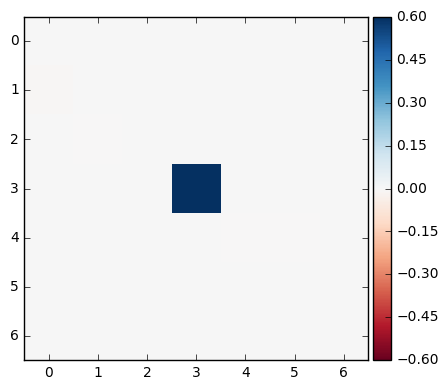

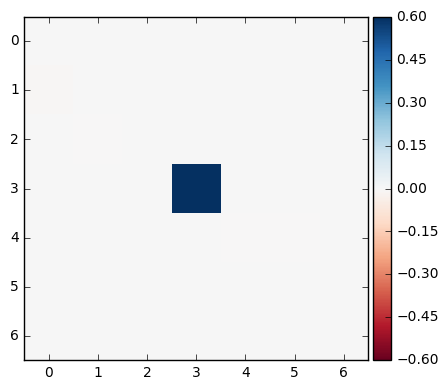

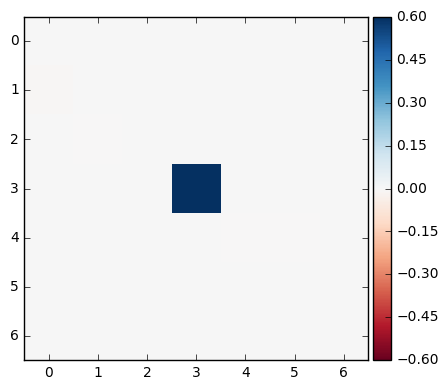

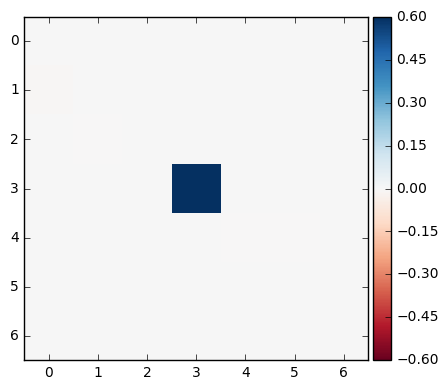

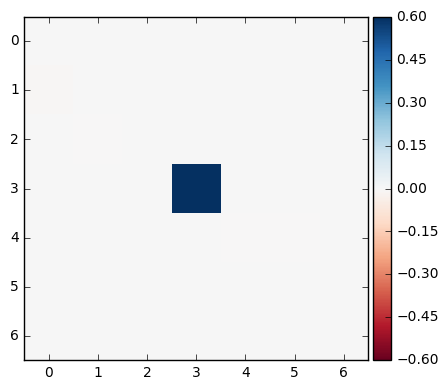

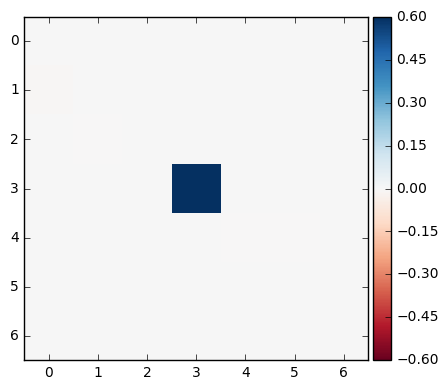

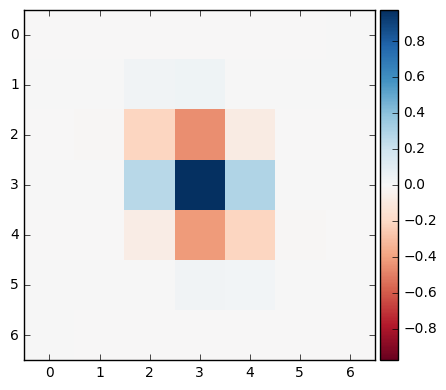

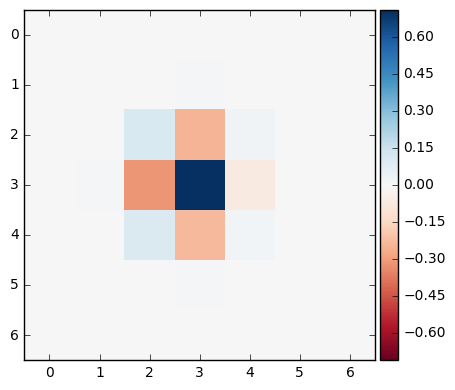

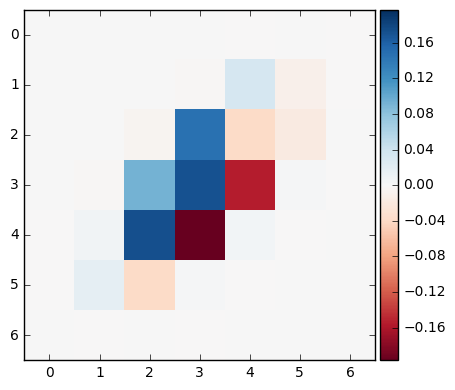

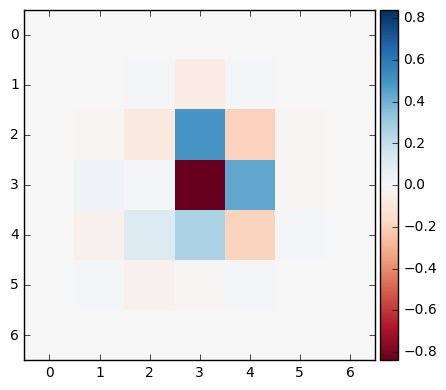

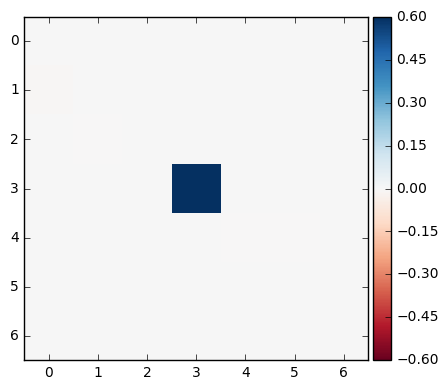

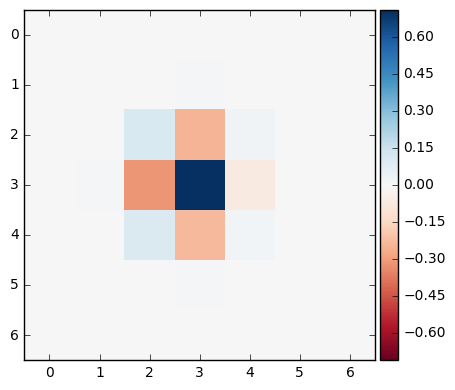

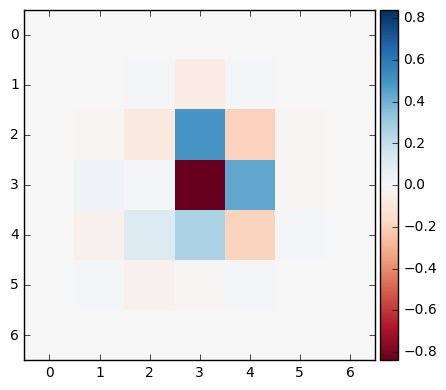

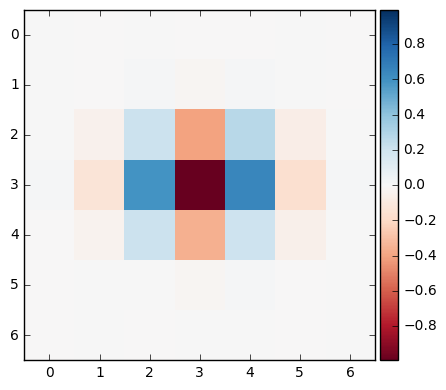

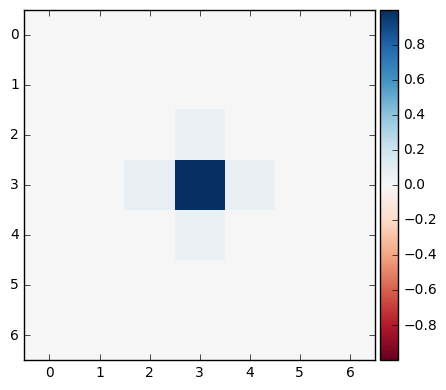

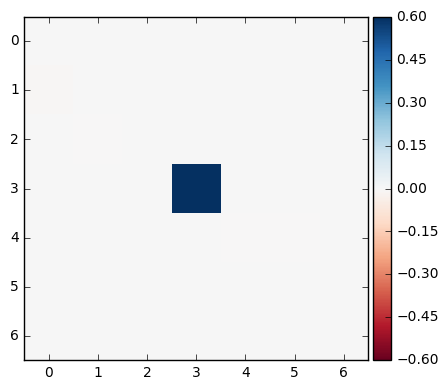

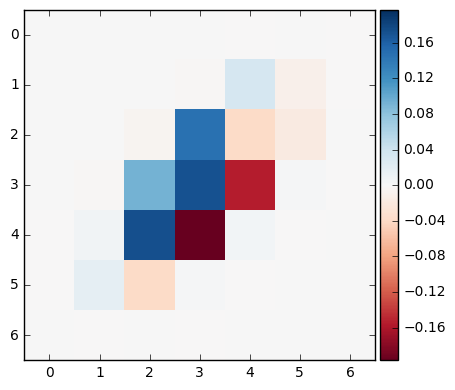

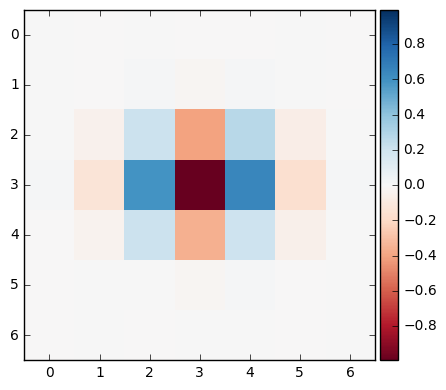

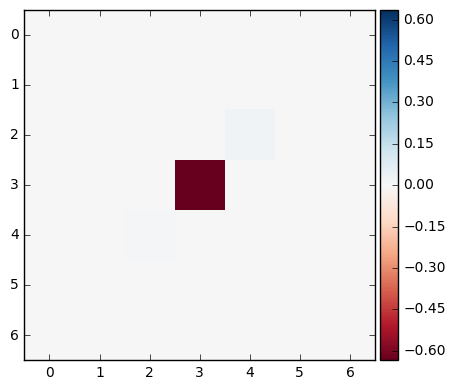

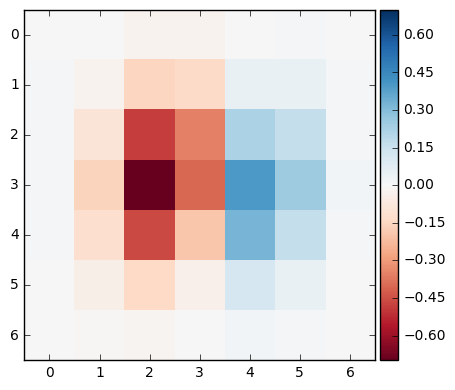

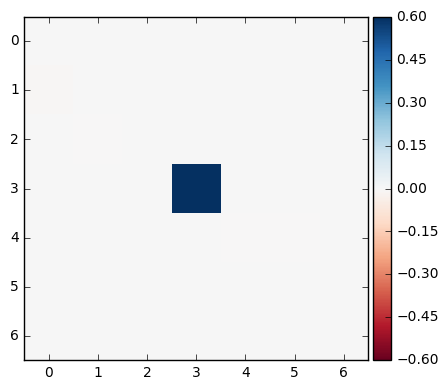

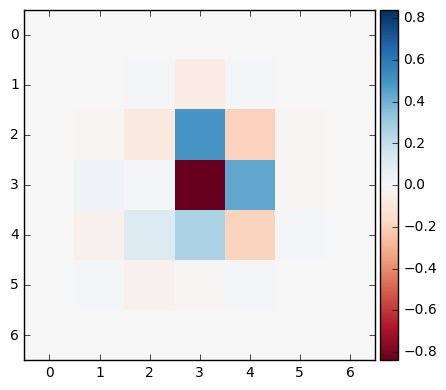

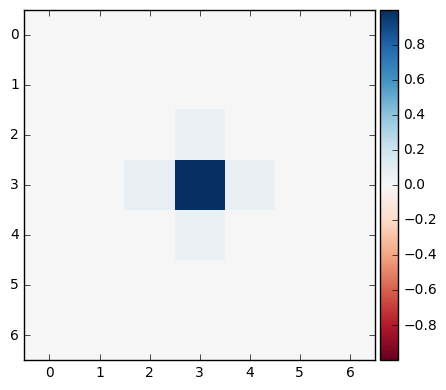

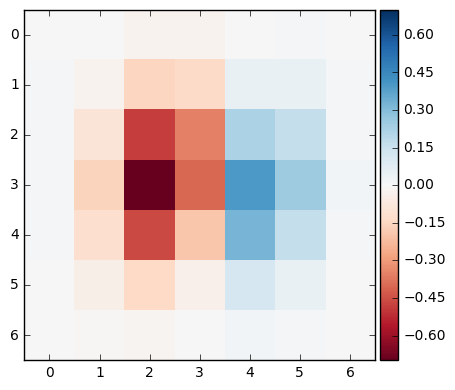

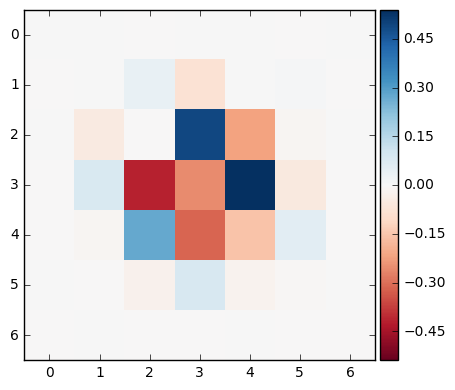

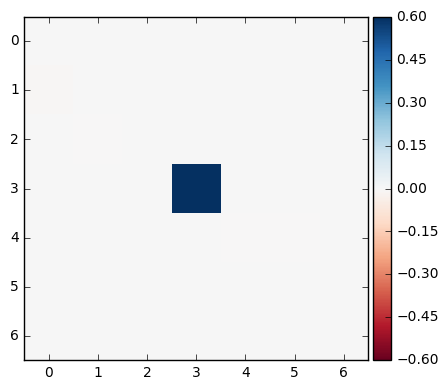

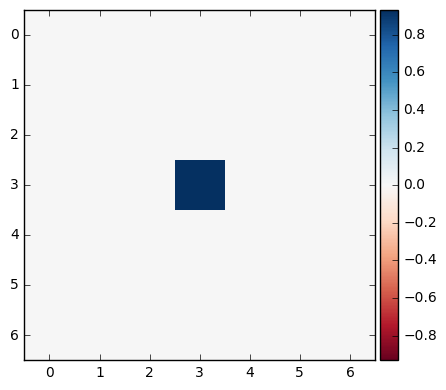

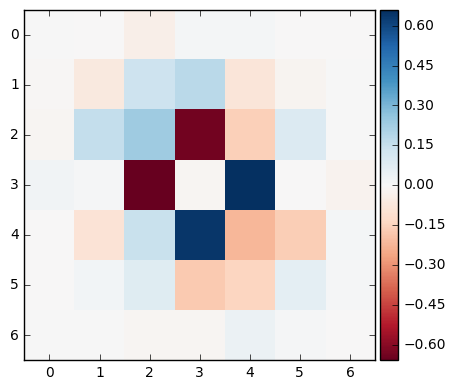

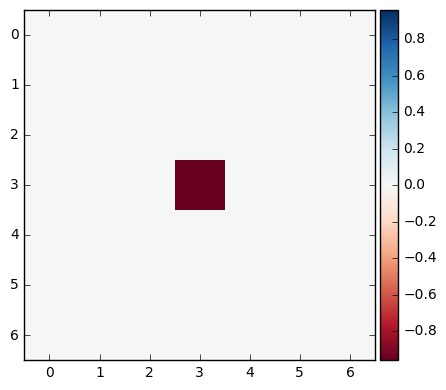

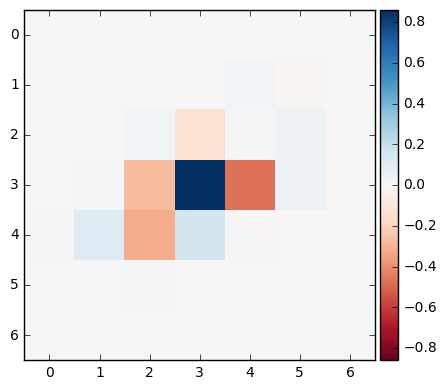

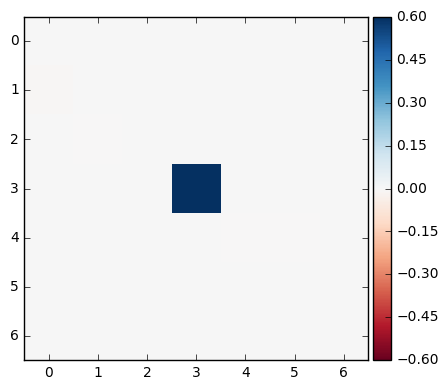

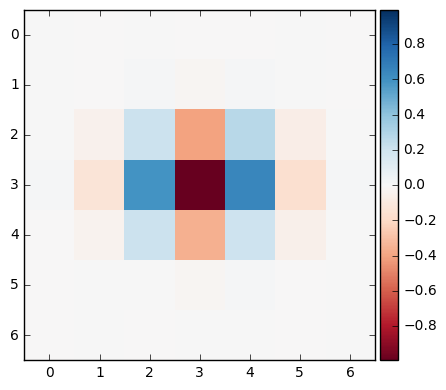

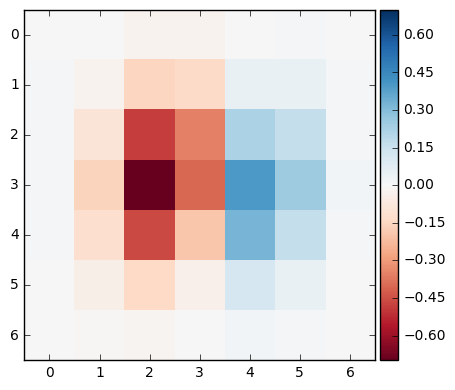

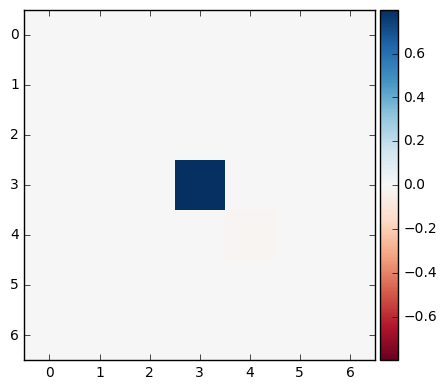

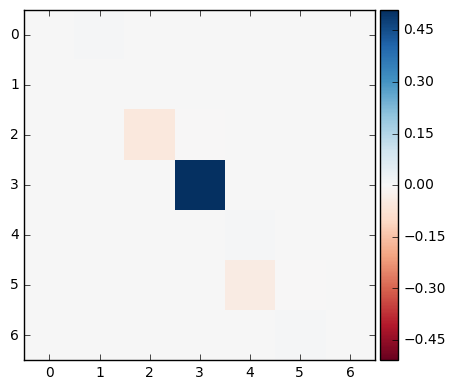

In [57]:
print('Gabor')
for i in range(g1_weights.shape[0]):
    for j in range(g1_weights.shape[1]):
        plt.figure()
        io.imshow(g1_weights[i,j].cpu().detach().numpy())
        io.show()

Conv


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


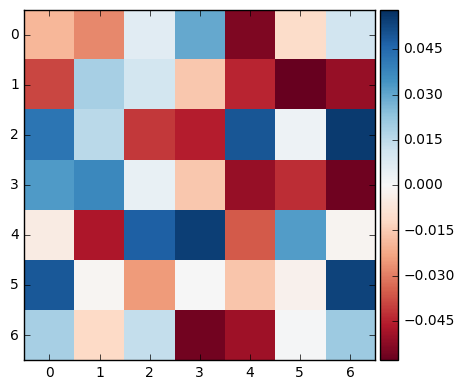

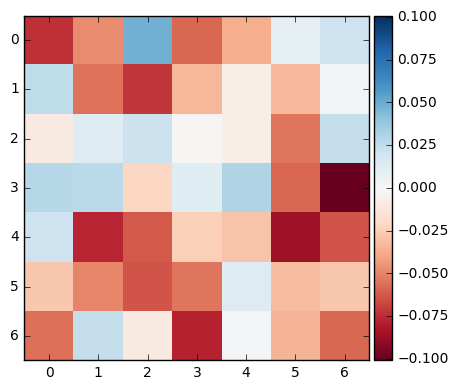

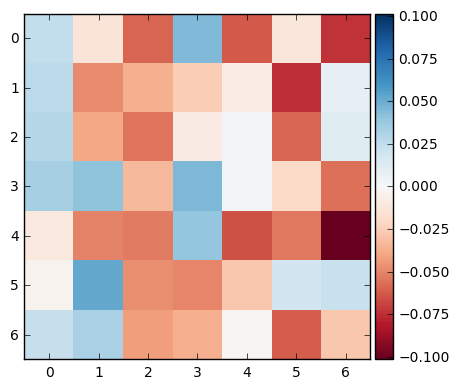

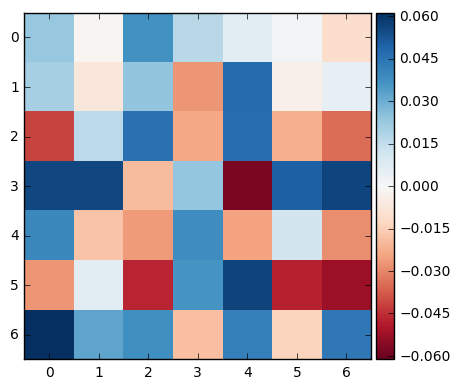

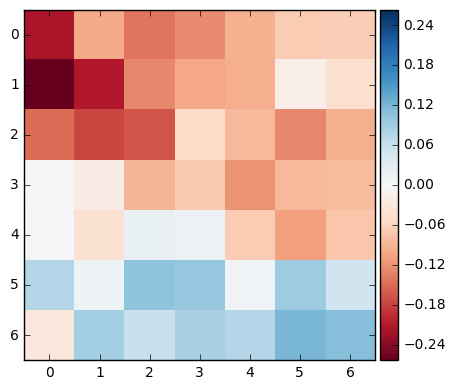

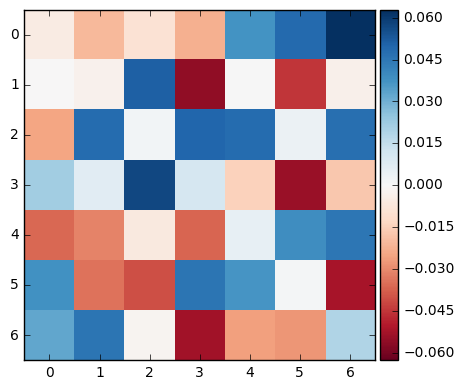

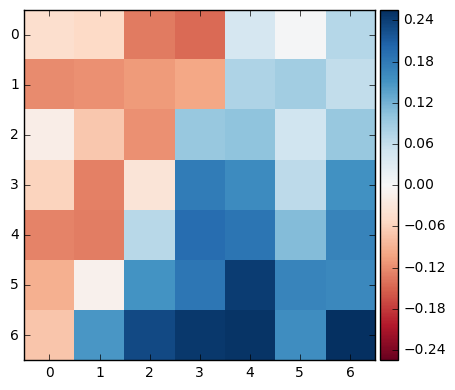

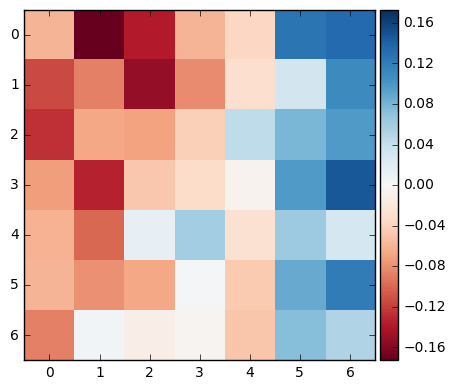

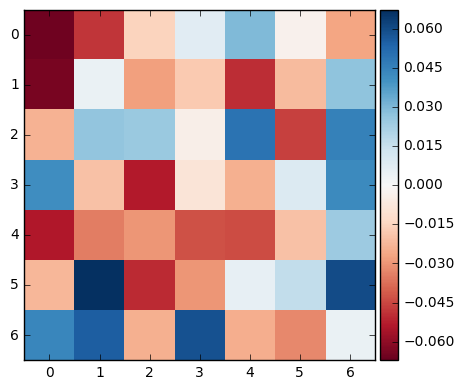

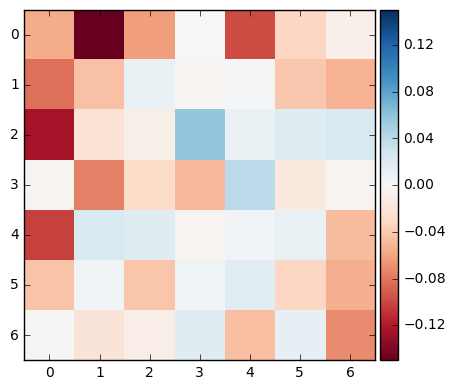

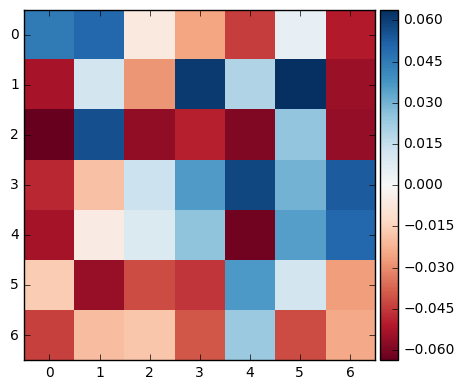

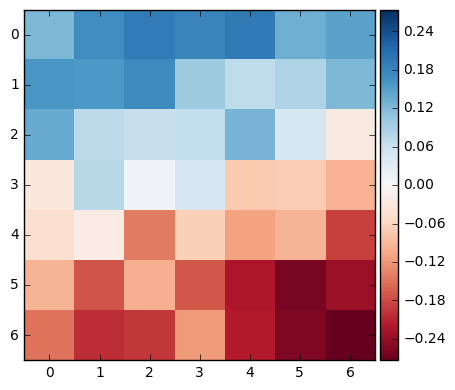

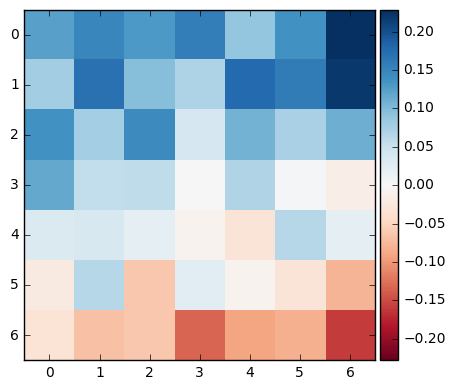

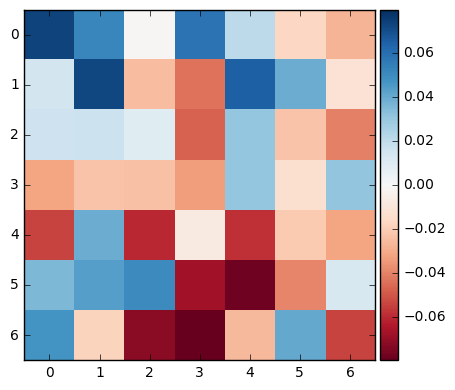

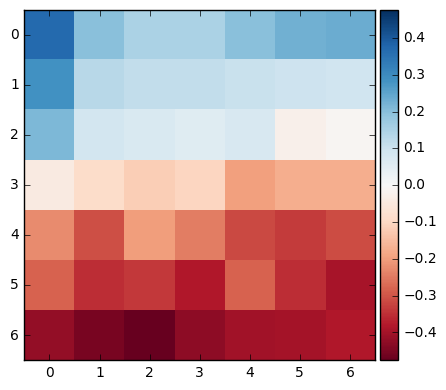

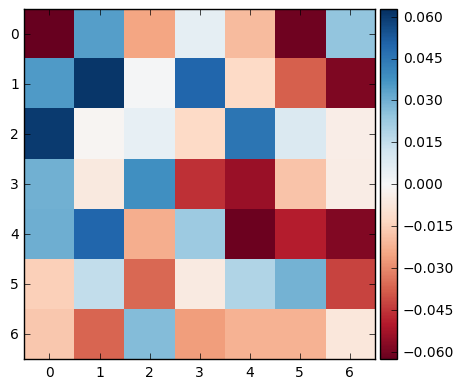

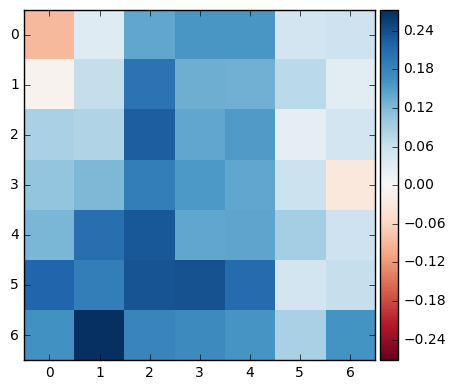

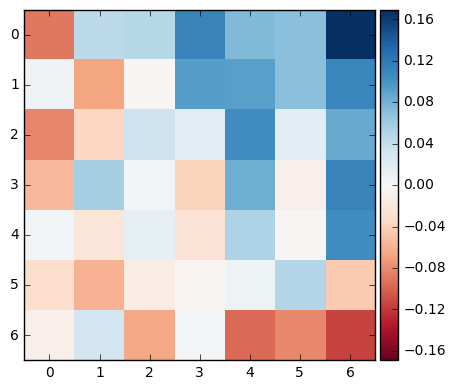

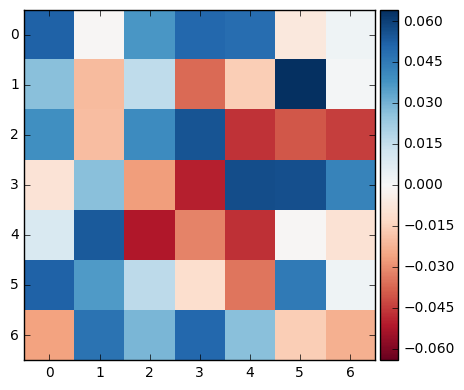

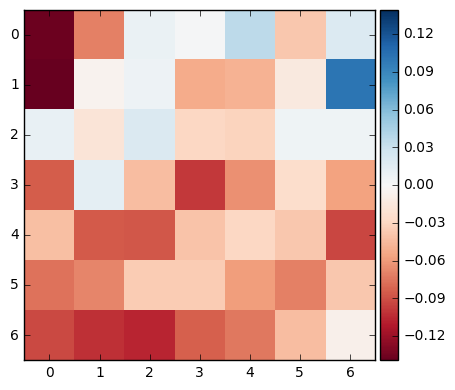

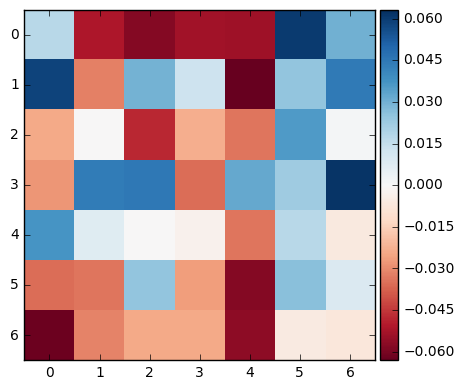

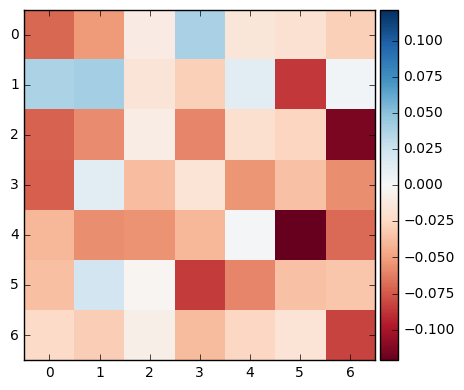

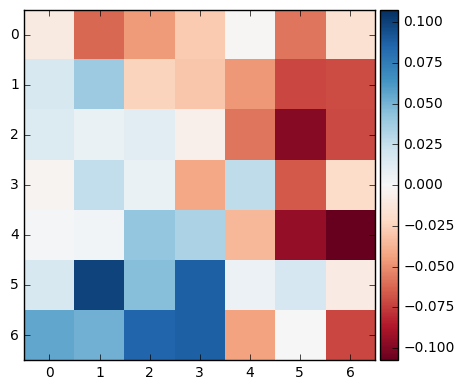

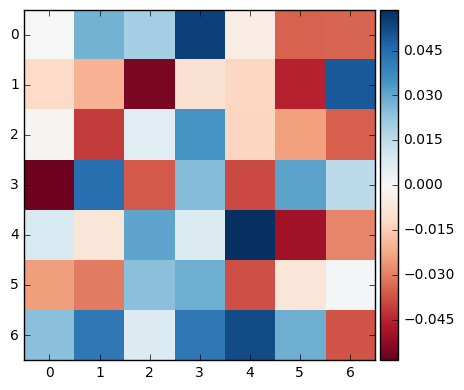

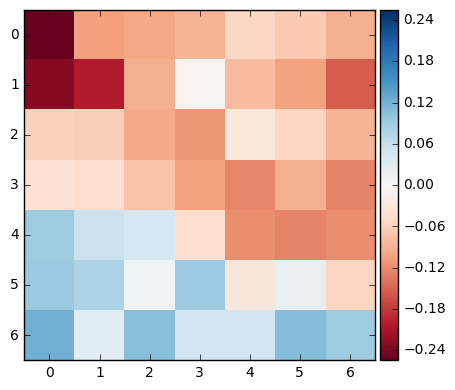

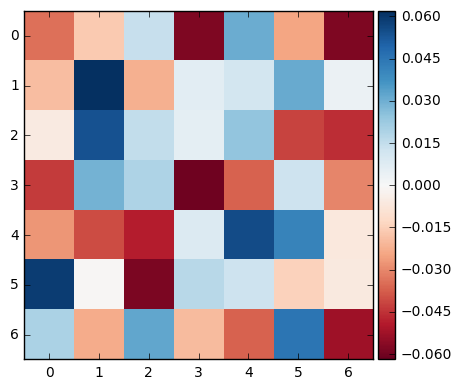

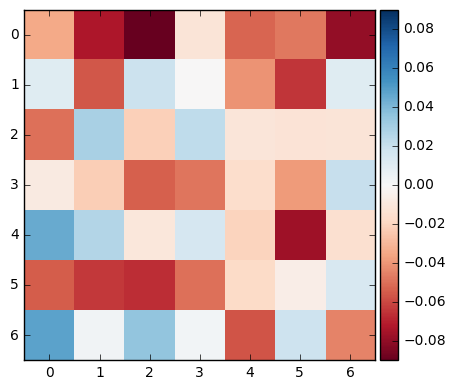

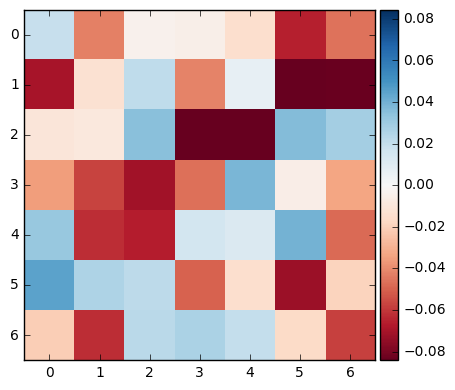

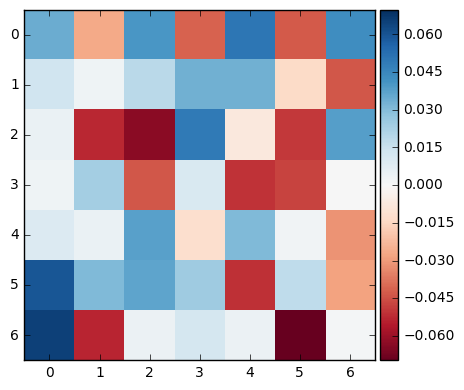

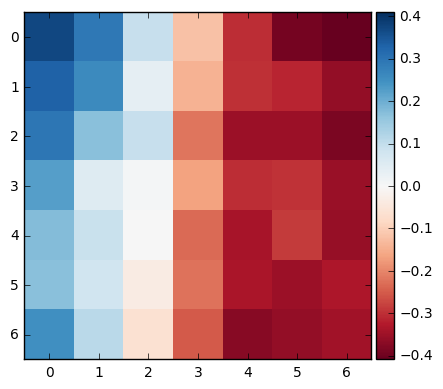

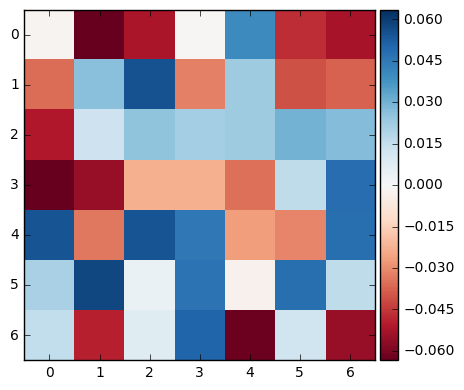

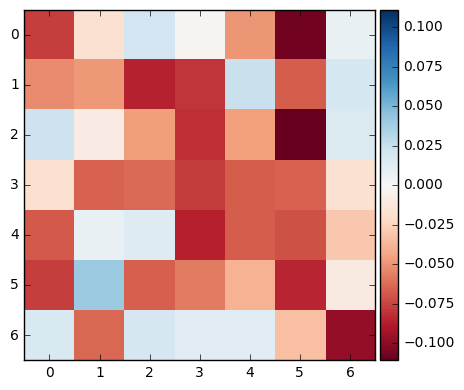

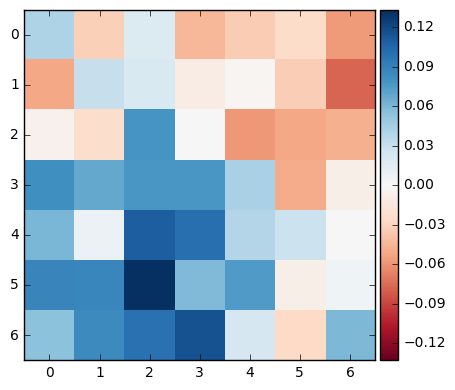

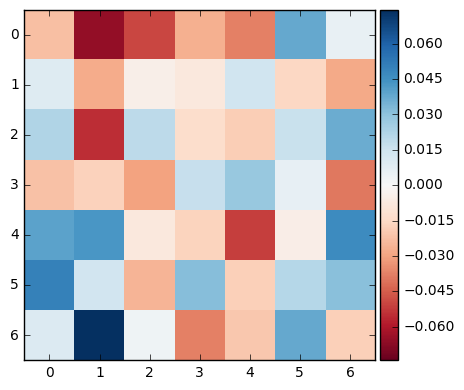

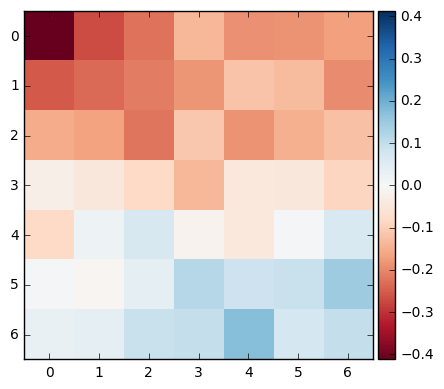

In [59]:
c1_weights = convnet.c3.weight
print('Conv')        
for i in range(c1_weights.shape[0]):
    for j in range(c1_weights.shape[1]):
        plt.figure()
        io.imshow(c1_weights[i,j].cpu().detach().numpy())
        io.show()